<a href="https://colab.research.google.com/github/michalinahulak/Novozymes_Enzyme_Stability/blob/main/Enzyme_Stability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.7 MB/s eta 0:00:00


In [3]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.7 MB/s eta 0:00:00


# Imports

In [84]:
import pandas as pd
import numpy as np

#visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNetCV
 
import math

import re

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import optuna

from Bio.Seq import Seq

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array


from PIL import Image

# Functions

In [5]:
def get_kmer_counts(seq):
    kmer_counts = {}
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1
    return kmer_counts

In [6]:
def return_amino_acid(df):
  amino_acids=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
  for amino_acid in amino_acids:
    df[amino_acid]=df['protein_sequence'].str.count(amino_acid,re.I)/df['protein_length']
  return df

# Loading dataset


In [72]:
url = 'https://github.com/michalinahulak/Novozymes_Enzyme_Stability/raw/main/enzyme_stability_dataset.csv'
data = pd.read_csv(url)
data.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


# Basic information

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  28981 non-null  object 
 1   pH                28695 non-null  float64
 2   data_source       28001 non-null  object 
 3   tm                28981 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.1+ MB


In [21]:
data.describe()

,pH,tm
count,28695.000000,28981.000000
mean,6.872467,51.360005
std,0.793184,12.056717
min,1.990000,25.100000
25%,7.000000,43.600000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


# Preprocessing

## Missing values
Missing values ​​are only in train dataset.

*   'data_source' - 980 missing values
*   'pH' - 286 missing values

'data_source' will be not use in modelling so it can contains missing values. 
Column 'pH' is very important and missing values ​​account less than 1% of all values, therefore rows containing missing values ​​in the 'pH' column will be deleted.

In [22]:
# missing values df_train

data.isnull().sum().sort_values(ascending = False)

data_source         980
pH                  286
protein_sequence      0
tm                    0
dtype: int64

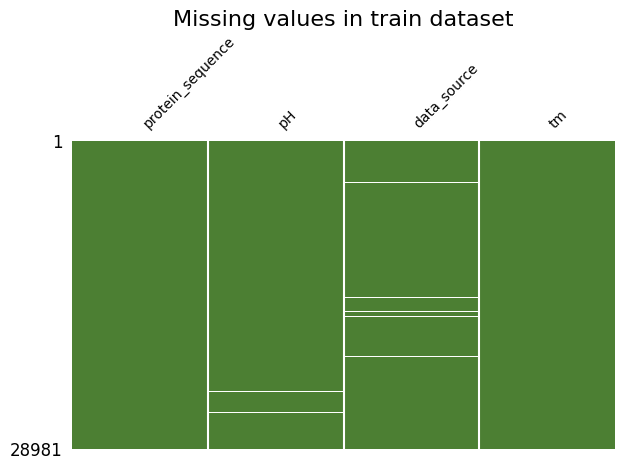

In [23]:
msno.matrix(data, figsize=(7,4), color = (0.3, 0.5, 0.2), fontsize = 10, sparkline = False)
plt.title('Missing values in train dataset', fontdict = {'fontsize':16})
plt.show(); 

In [73]:
# remove rows with missing values in 'pH' column and remove 'data_source' column

data = data.dropna(subset=['pH'])\
        .drop('data_source', axis=1)

## 'protein_length'

In [74]:
scaler = MinMaxScaler()

data['protein_length'] = data['protein_sequence'].apply(lambda x: len(x))
data['protein_length_normalized'] = scaler.fit_transform(data[['protein_length']])
# data['pH'] = scaler.fit_transform(data[['pH']])

In [30]:
data.head(3)

,protein_sequence,pH,tm,protein_length,protein_length_normalized
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,0.556049,75.7,341,0.038212
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,0.556049,50.5,286,0.031957
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,0.556049,40.5,497,0.055954


In [58]:
data.describe()

,seq_id,pH,tm,protein_length,protein_length_normalized
count,28695.000000,28695.000000,28695.000000,28695.000000,28695.000000
mean,15631.432166,6.872467,51.385604,451.729535,0.050805
std,9235.099078,0.793184,12.076609,416.889872,0.047412
min,0.000000,1.990000,25.100000,5.000000,0.000000
25%,7447.500000,7.000000,43.700000,210.000000,0.023314
50%,15443.000000,7.000000,48.800000,352.000000,0.039463
75%,23758.500000,7.000000,54.600000,537.000000,0.060503
max,31389.000000,11.000000,130.000000,8798.000000,1.000000


The length of protein sequences varies greatly, ranging from 5 to over 8000. I suggest selecting a dataframe for sequences with lengths between 200 and 800.

In [75]:
df_selected = data.query('protein_length >= 200 and protein_length <= 800')


## K-mer counting

In [12]:
df_kmer = data.copy()

In [13]:
k = 3

kmer_counts = df_kmer['protein_sequence'].apply(get_kmer_counts)

# zamiana kmer_counts na dataframe z odpowiednią nazwą kolumny i odpowiednim indeksem
kmer_counts_df = pd.DataFrame.from_records(kmer_counts).fillna(0).astype(int)
kmer_counts_df.columns = [f"kmer_{k}_{kmer}" for kmer in kmer_counts_df.columns]
kmer_counts_df.index = df_kmer.index

# połączenie oryginalnego dataframe'u z kmer_counts_df
df_kmer = pd.concat([df_kmer, kmer_counts_df], axis=1)

In [29]:
df_kmer.head(3)

,protein_sequence,pH,tm,protein_length,protein_length_normalized,kmer_3_AAA,kmer_3_AAK,kmer_3_AKA,kmer_3_KAA,kmer_3_AAL,...,kmer_3_CMY,kmer_3_WMH,kmer_3_CWP,kmer_3_MCM,kmer_3_WCC,kmer_3_HMW,kmer_3_WHC,kmer_3_CWW,kmer_3_WKW,kmer_3_WCW
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,3,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,4,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##Amino acid

### all dataset

In [34]:
df_amino = data.copy()

In [35]:
df_amino = return_amino_acid(df_amino)
df_amino.head(3)

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,A,C,D,E,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,0.131965,0.002933,0.038123,0.087977,...,0.023460,0.014663,0.052786,0.017595,0.073314,0.032258,0.041056,0.108504,0.011730,0.008798
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,0.097902,0.000000,0.034965,0.181818,...,0.006993,0.020979,0.027972,0.076923,0.104895,0.048951,0.041958,0.045455,0.010490,0.010490
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,0.100604,0.018109,0.054326,0.064386,...,0.012072,0.030181,0.040241,0.050302,0.062374,0.066398,0.060362,0.060362,0.006036,0.032193


### selected dataset

In [76]:
df_selected_amino = df_selected.copy()
df_selected_amino = return_amino_acid(df_selected_amino)
df_selected_amino.head(3)

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,A,C,D,E,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,0.131965,0.002933,0.038123,0.087977,...,0.023460,0.014663,0.052786,0.017595,0.073314,0.032258,0.041056,0.108504,0.011730,0.008798
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,0.097902,0.000000,0.034965,0.181818,...,0.006993,0.020979,0.027972,0.076923,0.104895,0.048951,0.041958,0.045455,0.010490,0.010490
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,0.100604,0.018109,0.054326,0.064386,...,0.012072,0.030181,0.040241,0.050302,0.062374,0.066398,0.060362,0.060362,0.006036,0.032193


## ... 

Tutaj wyciągnięte są powtarzające się trójki w sekwencji białka. Nie wiem tylko, jak dalej to przekonwertować, aby włożyć do modelu

In [36]:
import re
data_bio = data.copy()
domains = []
for sequence in data_bio['protein_sequence']:
    # szukamy wzorców łańcuchów aminokwasów o długości od 3 do 5,
    # które powtarzają się co najmniej 2 razy i są oddalone od siebie
    # maksymalnie o 50 aminokwasów
    pattern = re.compile(r'(?=(\w{3,5})(\w{0,50}\1){1})')
    matches = pattern.findall(sequence)
    domain = [match[0] for match in matches]
    domains.append(domain)

data_bio['domains'] = domains


In [37]:
data_bio

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,domains
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,"[AAA, AAA, RLE, GGE, TTG, VGV, VNL, LSLL, SLL,..."
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,"[GSR, AQR, AQR, QAR, RKAQ, KAQ, QREAE, REAE, E..."
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,"[LAK, GGG, GGF, GFG, GTK, TVR, AGA, GAS, PGA, ..."
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,0.029569,"[SGL, LLQP, LQP, GLL, EDE]"
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,0.164449,"[SVR, ATT, RVE, SDV, IVV, PMS, LGS, RNS, SSS, ..."
...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,0.061867,"[GGG, FNQ, ALL, LEI, GGS, ARN, ELR, LCL, DSR]"
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,0.052769,"[AMF, ETL, STR, RLS, LAAG, AAG]"
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,0.013988,[PSG]
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,0.066871,"[GVV, GTVG, TVG, IVQ, KEE]"


# Models for k-mer set

dataset z k-mer bardzo długo się liczy (nic dziwnego, jak kolumn jest ponad 8000, ale zostawiam wyniki tych dwóch modeli po porstu do wglądu).

In [15]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    # 'ElasticNetCV': ElasticNetCV(l1_ratio = 0.5, cv=10, random_state=0),
    # 'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=20, n_estimators=250, random_state=8),
    'CatBoostRegressor' : CatBoostRegressor(iterations=1000,
                           learning_rate=0.1,
                           depth=10,
                           loss_function='RMSE'),
    # 'LGBMRegressor': LGBMRegressor(objective= "regression", metric = "rmse", num_leaves = 1024, max_depth = 500, 
    #                            learning_rate = 0.1,)

}

In [14]:
# split df
X = df_kmer.drop(['protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_kmer['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
results_kmer = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]
    })
    results_kmer = pd.concat([results_kmer, results], ignore_index=True)

In [17]:
results_kmer

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,RandomForest,14.024573,91.734142,89.817641,2.625676,6.733020,6.712207,0.905334,0.372586,0.350883
1,CatBoostRegressor,15.797424,75.840777,75.214817,2.924441,6.501065,6.440109,0.893367,0.481288,0.456418


# Models for amino acid set

In [44]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'ElasticNetCV': ElasticNetCV(l1_ratio = 0.5, cv=10, random_state=0),
    'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=20, n_estimators=250, random_state=8),
    'CatBoostRegressor' : CatBoostRegressor(iterations=1000,
                           learning_rate=0.1,
                           depth=10,
                           loss_function='RMSE'),
    'LGBMRegressor': LGBMRegressor(objective= "regression", metric = "rmse", num_leaves = 1024, max_depth = 500, 
                               learning_rate = 0.1,)

}

## all dataset

In [43]:
# split X, y for df_train_amino

X = df_amino.drop(['protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_amino['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
results_aminoacid = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]
    })
    results_aminoacid = pd.concat([results_aminoacid, results], ignore_index=True)


In [36]:
results_aminoacid

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,RandomForest,9.430715,56.848431,57.305677,2.191390,5.469111,5.487334,0.936342,0.611186,0.585849
1,ElasticNetCV,110.048820,110.775761,105.493884,8.104656,8.099073,7.942555,0.257167,0.242351,0.237590
2,XGBRegressor,1.620910,61.202542,61.162252,0.226129,5.629194,5.580040,0.989059,0.581406,0.557977
3,CatBoostRegressor,5.334928,54.148302,54.427956,1.506547,5.391396,5.385877,0.963989,0.629653,0.606646
4,LGBMRegressor,4.043535,55.859857,56.982782,1.009341,5.459793,5.476191,0.972706,0.617947,0.588182


## selected dataset

In [77]:
# split X, y for df_train_amino

X = df_selected_amino.drop(['protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_selected_amino['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
results_selected_aminoacid = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]
    })
    results_selected_aminoacid = pd.concat([results_selected_aminoacid, results], ignore_index=True)


In [79]:
results_selected_aminoacid

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,RandomForest,8.112049,54.402253,56.394869,2.073318,5.405061,5.509321,0.944338,0.620646,0.623089
1,ElasticNetCV,145.699355,143.414258,149.552003,8.594129,8.497509,8.614734,0.000267,-0.000046,0.000481
2,XGBRegressor,0.000004,54.626376,59.479950,0.000712,5.437500,5.619090,1.000000,0.619083,0.602470
3,CatBoostRegressor,1.934057,50.149520,53.672306,0.778339,5.297522,5.402233,0.986729,0.650301,0.641285
4,LGBMRegressor,2.409432,54.119795,56.444668,0.767023,5.442777,5.540230,0.983467,0.622616,0.622757


## Optuna
searching for the best hyperparameters for CatBoostRegressor

In [80]:
# split X, y for df_train_amino

X = df_selected_amino.drop(['protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_selected_amino['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
def catboost_objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000, step=500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 5, 15),
        'loss_function': 'RMSE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'random_seed': 42,
        'silent': True
    }

    # Train the model and make predictions
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_val)

    # Compute the loss
    loss = mean_squared_error(y_val, y_pred, squared=False)

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(catboost_objective, n_trials=10)

print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

In [ ]:
# [I 2023-05-02 19:24:08,844] Trial 8 finished with value: 7.208425679872539 and parameters: {'iterations': 1000, 'learning_rate': 0.035290781378874744, 'depth': 11}. Best is trial 8 with value: 7.208425679872539.
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

In [49]:
model = CatBoostRegressor(iterations=1000,
                           learning_rate=0.035290781378874744,
                           depth=11)

In [ ]:
model.fit(X_train, y_train.values.ravel())
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)
results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]})


In [53]:
results

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,XGBRegressor,11.733814,53.161637,53.456715,2.471989,5.351472,5.364638,0.920796,0.636402,0.613665


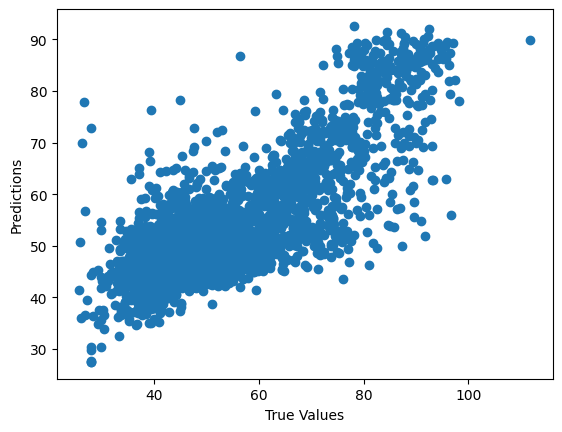

In [54]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# transfer learning

In [82]:
df_tl = data.copy()

In [85]:
# Tworzenie słownika przypisującego aminokwasom wartości pikseli
aa_to_pixel = {
    'A': [255, 255, 255],  # Biały
    'R': [255, 0, 0],      # Czerwony
    'N': [255, 255, 0],    # Żółty
    'D': [255, 128, 0],    # Pomarańczowy
    'C': [0, 255, 0],      # Zielony
    'E': [128, 128, 128],  # Szary
    'Q': [0, 255, 255],    # Jasnoniebieski
    'G': [0, 0, 255],      # Niebieski
    'H': [255, 0, 255],    # Fioletowy
    'I': [0, 128, 0],      # Ciemnozielony
    'L': [0, 128, 128],    # Ciemnoniebieski
    'K': [0, 0, 128],      # Granatowy
    'M': [128, 0, 128],    # Purpurowy
    'F': [128, 0, 0],      # Ciemnoczerwony
    'P': [192, 192, 192],  # Srebrny
    'S': [128, 128, 0],    # Oliwkowy
    'T': [0, 128, 128],    # Turkusowy
    'W': [0, 0, 0],        # Czarny
    'Y': [255, 255, 128],  # Jasnobeżowy
    'V': [128, 128, 128]   # Szary
}


# Przetwarzanie sekwencji białkowych na obrazy o wymiarach (64, 64, 3)
images = []
for sequence in df_tl['protein_sequence']:
    seq = Seq(sequence)
    seq_len = len(seq)
    img = Image.new('RGB', (64, 64), color = 'white')
    pixels = img.load()
    for i, aa in enumerate(seq):
        if i >= 501:
            break
        pixel = tuple(aa_to_pixel[aa])
        pixels[i % 64, i // 64] = pixel
    img = img_to_array(img)
    images.append(img)


In [86]:
X = np.array(images)
y = df_tl['tm'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [87]:
# Wczytanie wytrenowanego modelu ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Zamrożenie wag wstępnie wytrenowanych warstw
for layer in base_model.layers:
    layer.trainable = False

# Dodanie warstwy wyjściowej
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)

# Stworzenie nowego modelu z wykorzystaniem wstępnie wytrenowanego ResNet50V2
model = Model(inputs=base_model.input, outputs=x)

# Kompilacja modelu
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=['mae'])

# Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


94668760/94668760 [==============================] - 1s 0us/step


Epoch 1/10
539/539 [==============================] - 370s 676ms/step - loss: 39671.8516 - mae: 49.2949 - val_loss: 199.8835 - val_mae: 9.6470
Epoch 2/10
539/539 [==============================] - 337s 625ms/step - loss: 688.6287 - mae: 20.9217 - val_loss: 211.7474 - val_mae: 10.0400
Epoch 3/10
539/539 [==============================] - 336s 623ms/step - loss: 685.4400 - mae: 20.8043 - val_loss: 299.5166 - val_mae: 13.0908
Epoch 4/10
539/539 [==============================] - 327s 608ms/step - loss: 733.4373 - mae: 21.3188 - val_loss: 245.2379 - val_mae: 11.2432
Epoch 5/10
539/539 [==============================] - 314s 583ms/step - loss: 698.8620 - mae: 21.1049 - val_loss: 183.3719 - val_mae: 9.2247
Epoch 6/10
539/539 [==============================] - 325s 603ms/step - loss: 690.1578 - mae: 20.9536 - val_loss: 258.0143 - val_mae: 11.7493
Epoch 7/10
539/539 [==============================] - 314s 582ms/step - loss: 671.2824 - mae: 20.6941 - val_loss: 186.2126 - val_mae: 9.3672
Epoch 8

In [88]:
loss_test, mae_test = model.evaluate(X_test, y_test)
print(f'Test loss: {loss_test}, Test MAE {mae_test}')

180/180 [==============================] - 93s 515ms/step - loss: 137.2951 - mae: 7.9567
Test loss: 137.29513549804688, Test MAE 7.956679344177246
